<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# Eletronics Purchase Prediction

Today you are a machine learning engineer in the Department of Marketing and Inventory at Walmart Labs. You have access to the Walmart server data, specifically the Electronics section. However, there is no customer facing information, but you do have access to timestamped data regarding product viewing/carting/purchasing. We will use this data to build a model of whether or not some product will be purchased.

Data is adapted from [e-commerce behavior data on Kaggle](https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store). 

This file contains behavior data from a large multi-category store. Each row in the file rerepresents an event. All events are related to products and users. Each event is like many-many relation between users and products. 

## Learning Objectives

At the end of this session, you will be able to
- Detect data imbalance
- Practice more on preprocessing features
- Build logistic regression / SVM / Gradient Boosting / Random Forest models
- Evaluate models with proper metrics
- Interpret black box models

## Task 1: Load data

We start by looking at the descriptions before loading in the csv files.

1. Use the `IPython.display` module to view the `some_column_descriptions.png` file. Look through the column names and descriptions to get an idea of what the data is.

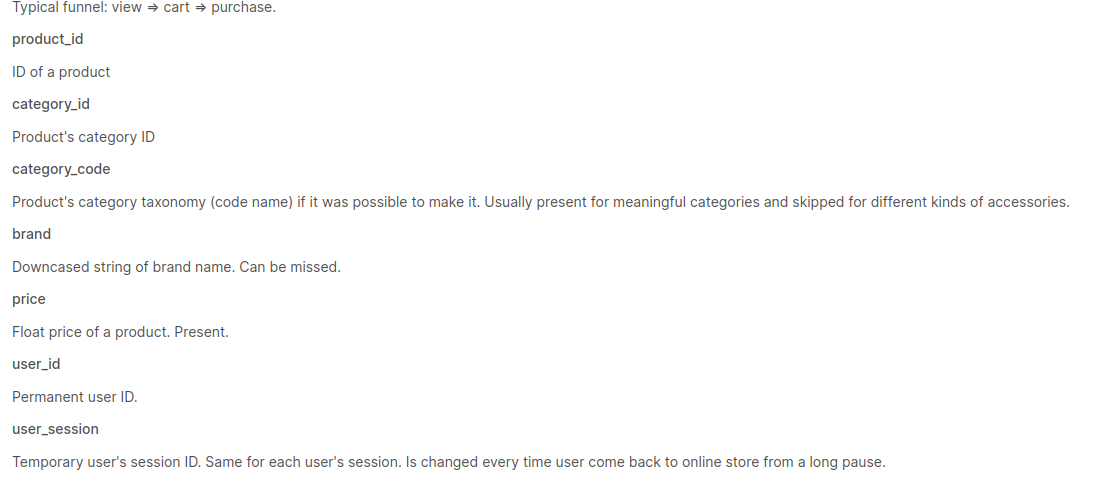

In [1]:
import numpy as np
import pandas as pd 
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import plotly 
import sklearn 
import shap
import tpot
import streamlit as st

from IPython.display import Image, display
# change the filename to wherever you downloaded/uploaded the file
filename = '../img/some_column_descriptions.png'
display(Image(filename=filename))

The dataset has User-journey data, i.e., it tracks information user/product pairs over time to see if the combination results in a purchase.

2. Look at the `user_journey_descriptions.png` file. Review the data sample to get a sense of what information we are tracking for each user/product pair.

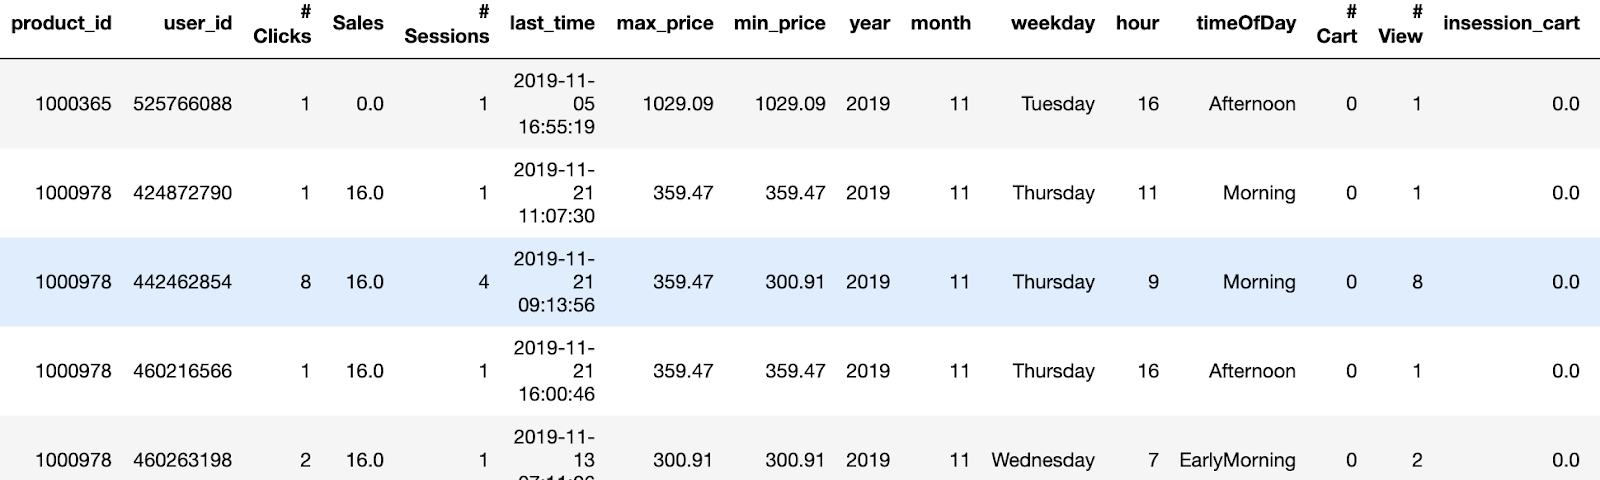

In [2]:
# change path to wherever you uploaded/downloaded the file
filename='../img/user_journey_descriptions.png'
display(Image(filename=filename))

The dataset we are working with is essentially what we have screenshotted above, but has been anonymized by removing product IDs and user IDs.

3. Use the pandas `read_csv()` and `head()` functions to read in the training data (`../dat/train.csv.gz`) and look at the first few rows.

    Note the `Purchase` column has either 0 (not purchased) or 1 (purchased).

In [3]:
import pandas as pd
train_df = pd.read_csv("../dat/train.csv.gz")# YOUR CODE HERE

In [4]:
# YOUR CODE HERE
train_df.head(5)

NumOfEventsInJourney  NumSessions  interactionTime  maxPrice  minPrice  \
0                     1            1              0.0    154.41    154.41   
1                     1            1              0.0     92.67     92.67   
2                     1            1              0.0    155.71    155.71   
3                     1            1              0.0    898.32    898.32   
4                     1            1              0.0    146.21    146.21   

   NumCart  NumView  InsessionCart  InsessionView  year  month weekday  \
0        0        1              0              1  2019     11     Sat   
1        0        1              0              1  2019     11      Fr   
2        0        1              0              1  2019     11     Thu   
3        0        1              0              1  2019     11     Mon   
4        0        1              0              1  2019     11     Tue   

   timeOfDay  Weekend  Purchase  
0    Morning        0         0  
1       Dawn        0         0  
2  Afternoon        0         0  
3       Noon        0         0  
4       Noon        0         0

4. What is the dimension of the training data?

In [5]:
train_df.shape
# YOUR CODE HERE # (645816, 15)

(645816, 15)

5. Similarly, read in the test data `../dat/test.csv.gz` and check its dimension.

In [6]:
test_df = pd.read_csv("../dat/test.csv.gz")  # YOUR CODE HERE
test_df.shape # (430544, 15)


(430544, 15)

## Task 2: Understand data

Our goal here is to predict whether a customer/product pair will result in a purchase. As part of this, we will want to identify what features are most important for making this classification.

We'll start with digging into our dataset.

1. For the training data, print out the datatype of each feature (column), and identify which ones are non-numeric.

In [8]:
train_df.dtypes
train_df_nonnumeric = train_df.select_dtypes(exclude=['int', 'float'])
train_df_nonnumeric.head(5)
# YOUR CODE HERE

weekday  timeOfDay
0     Sat    Morning
1      Fr       Dawn
2     Thu  Afternoon
3     Mon       Noon
4     Tue       Noon

<details> 
<summary>Expected output:</summary>

    NumOfEventsInJourney      int64
    NumSessions               int64
    interactionTime         float64
    maxPrice                float64
    minPrice                float64
    NumCart                   int64
    NumView                   int64
    InsessionCart             int64
    InsessionView             int64
    year                      int64
    month                     int64
    weekday                  object
    timeOfDay                object
    Weekend                   int64
    Purchase                  int64
    dtype: object
</details>

2. Print the unique values for the year, month and weekend features.

In [9]:
print('   year:', train_df.year.unique())  # YOUR CODE HERE # [2019]
print('  month:', train_df.month.unique())  # YOUR CODE HERE # [11]
print('weekend:', train_df.Weekend.unique())  # YOUR CODE HERE # [0]


   year: [2019]
  month: [11]
weekend: [0]


In [10]:
print('weekend:', train_df.Weekend.value_counts()) 

weekend: 0    645816
Name: Weekend, dtype: int64


What does weekend: 0 mean?

3. Since these columns each only have one unique value, they will not be valuable features, we drop the three columns in the training set. Pass the `columns` argument to the `.drop()` method. Make sure to use `inplace=True` to modify the DataFrame. Print the shape of the DataFrames to verify the columns were dropped.

In [11]:
print(train_df.shape) 
columns = ["year", "month", "Weekend"]
train_df.drop(columns=columns, inplace=True)  # YOUR CODE HERE
print(train_df.shape)


(645816, 15)
(645816, 12)


<details> 
<summary>Expected output:</summary>

   (645816, 15)
   
   (645816, 12)
</details>

4. Repeat the step for `test_df`:

In [12]:
print(test_df.shape)
test_df.drop(columns=columns, inplace=True)  # YOUR CODE HERE
print(test_df.shape)

(430544, 15)
(430544, 12)


<details> 
<summary>Expected output:</summary>

(430544, 15)

(430544, 12)
</details>

4. For each non-numeric feature, print the unique values.

In [13]:
print('  weekday:', train_df.weekday.unique())   # YOUR CODE HERE 
print('timeOfDay:', train_df.timeOfDay.unique())   # YOUR CODE HERE

print('  weekday:', test_df.weekday.unique())   # YOUR CODE HERE 
print('timeOfDay:', test_df.timeOfDay.unique())   # YOUR CODE HERE

  weekday: ['Sat' 'Fr' 'Thu' 'Mon' 'Tue' 'Wed' 'Sun']
timeOfDay: ['Morning' 'Dawn' 'Afternoon' 'Noon' 'Evening' 'EarlyMorning' 'Night']
  weekday: ['Wed' 'Fr' 'Sat' 'Sun' 'Tue' 'Thu' 'Mon']
timeOfDay: ['EarlyMorning' 'Morning' 'Afternoon' 'Dawn' 'Evening' 'Night' 'Noon']


<details>
<summary> Expected output:</summary>
  
  weekday: ['Wed' 'Fr' 'Sat' 'Sun' 'Tue' 'Thu' 'Mon']

timeOfDay: ['EarlyMorning' 'Morning' 'Afternoon' 'Dawn' 'Evening' 'Night' 'Noon']
</details>

5. Convert the non-numeric features to numeric. 

    These feature values are ordered temporally, so it makes sense to do so. Follow the example given for the `weekday` column to update the `timeOfDay` column. Use the `.head()` method to inspect the dataset after the transformations.

In [14]:
weekday_str2num = {
    s: i+1 for i, s in enumerate(['Mon', 'Tue', 'Wed', 'Thu', 'Fr', 'Sat', 'Sun'])
}
train_df['weekday'] = train_df['weekday'].replace(weekday_str2num)
train_df.head()

NumOfEventsInJourney  NumSessions  interactionTime  maxPrice  minPrice  \
0                     1            1              0.0    154.41    154.41   
1                     1            1              0.0     92.67     92.67   
2                     1            1              0.0    155.71    155.71   
3                     1            1              0.0    898.32    898.32   
4                     1            1              0.0    146.21    146.21   

   NumCart  NumView  InsessionCart  InsessionView  weekday  timeOfDay  \
0        0        1              0              1        6    Morning   
1        0        1              0              1        5       Dawn   
2        0        1              0              1        4  Afternoon   
3        0        1              0              1        1       Noon   
4        0        1              0              1        2       Noon   

   Purchase  
0         0  
1         0  
2         0  
3         0  
4         0

In [15]:
timeOfDay_str2num = {
    s: i+1 for i, s in enumerate(['Dawn', 'EarlyMorning', 'Morning', 'Noon', 'Afternoon', 'Evening', 'Night'])
}
train_df['timeOfDay'] = train_df['timeOfDay'].replace(timeOfDay_str2num)
train_df.head()


NumOfEventsInJourney  NumSessions  interactionTime  maxPrice  minPrice  \
0                     1            1              0.0    154.41    154.41   
1                     1            1              0.0     92.67     92.67   
2                     1            1              0.0    155.71    155.71   
3                     1            1              0.0    898.32    898.32   
4                     1            1              0.0    146.21    146.21   

   NumCart  NumView  InsessionCart  InsessionView  weekday  timeOfDay  \
0        0        1              0              1        6          3   
1        0        1              0              1        5          1   
2        0        1              0              1        4          5   
3        0        1              0              1        1          4   
4        0        1              0              1        2          4   

   Purchase  
0         0  
1         0  
2         0  
3         0  
4         0

In [16]:
train_df.timeOfDay.unique() 

array([3, 1, 5, 4, 6, 2, 7])

<details>

<summary> Expected output:</summary>

array([3, 1, 5, 4, 6, 2, 7])
</details>

6. Do the same for `test_df`, that is, to convert `weekday` and `timeOfDay` into numeric. 

In [19]:
test_df['weekday'] = test_df['weekday'].replace(weekday_str2num)
test_df.head()
test_df['timeOfDay'] = test_df['timeOfDay'].replace(timeOfDay_str2num)
test_df.head()


NumOfEventsInJourney  NumSessions  interactionTime  maxPrice  minPrice  \
0                     1            1              0.0    126.86    126.86   
1                     2            2            182.0    118.38    118.38   
2                     1            1              0.0     63.77     63.77   
3                     1            1              0.0     32.18     32.18   
4                     1            1              0.0   1093.72   1093.72   

   NumCart  NumView  InsessionCart  InsessionView  weekday  timeOfDay  \
0        0        1              0              1        3          2   
1        0        2              0              1        5          2   
2        0        1              0              1        5          3   
3        0        1              0              3        5          2   
4        0        1              0              2        6          2   

   Purchase  
0         0  
1         0  
2         0  
3         0  
4         0

7. Use the `Purchase` column in training set to determine the proportion of user journeys that result in purchases.  Are the datasets balanced?

In [20]:
print("number of purchases vs non-purchases in train set:")
p = train_df.Purchase.value_counts()
print(p)
print("one value:p[1]")
print("zero value:p[1]")
print(p[0])
print(f"percent of rows resulting in purchase: {p[1]*100/(p[0]+p[1]):.2f}%") # YOUR CODE HERE



number of purchases vs non-purchases in train set:
0    636839
1      8977
Name: Purchase, dtype: int64
one value:p[1]
zero value:p[1]
636839
percent of rows resulting in purchase: 1.39%


<details>

<summary> Expected output:</summary>

    number of purchases vs non-purchases in train set:
    0    636839
    1      8977
    Name: Purchase, dtype: int64
    percent of rows resulting in purchase: 1.39%
<details>

## Task 3: Remove highly correlated features

Correlated features in general don't improve models (although it depends on the specifics of the problem like the number of variables and the degree of correlation), but they affect specific models in different ways and to varying extents:

- For linear models (e.g., linear regression or logistic regression), [multicolinearity](https://en.wikipedia.org/wiki/Multicollinearity) can yield [solutions that are wildly varying and possibly numerically unstable](https://en.wikipedia.org/wiki/Multicollinearity#Consequences).
- Random forests can be good at detecting interactions between different features, but highly correlated features can mask these interactions.
More generally, this can be viewed as a special case of [Occam's razor](https://en.wikipedia.org/wiki/Occam%27s_razor). A simpler model is preferable, and, in some sense, a model with fewer features is simpler. The concept of [minimum description length](https://en.wikipedia.org/wiki/Minimum_description_length) makes this more precise ([ref](https://datascience.stackexchange.com/questions/24452/in-supervised-learning-why-is-it-bad-to-have-correlated-features)).

1. How many features does our dataset currently have?

In [21]:
# YOUR CODE HERE
n = len(train_df.columns) -1
print(n)


11


<details>
<summary>Expected output:</summary>
    
    The training data currently has 11 features
</details>

2. Draw a heatmap of the Pearson correlation.

    The plotting code is given to you, but you need to fill in the calculation of the Pearson correlation (`pd.DataFrame.corr()`). Note that we here use a smaller sample of the total training dataset for calculating correlation and rendering heatmap. 

In [22]:
train_small_df = train_df.copy().sample(n=int(1e4), random_state=12) 

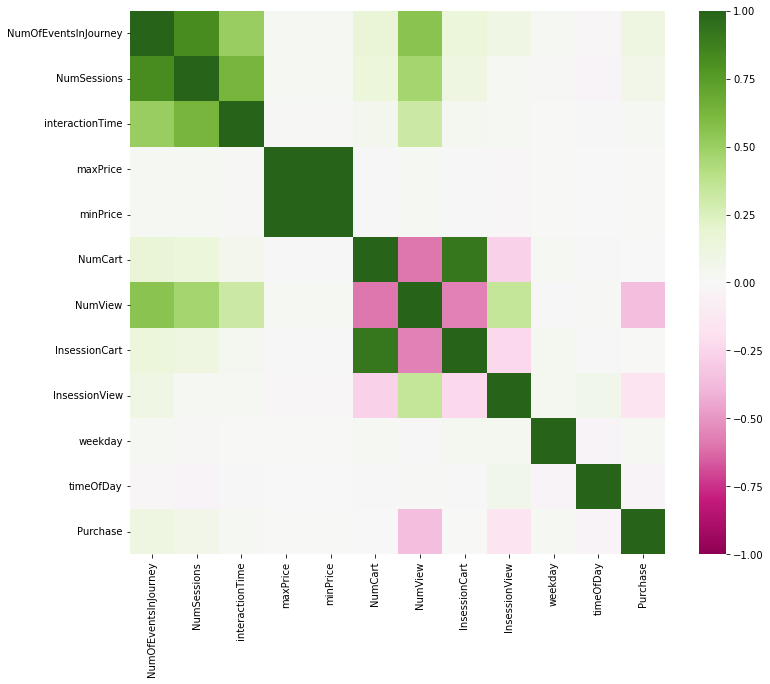

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
cor = pd.DataFrame.corr(train_small_df)  # YOUR CODE HERE
sns.heatmap(cor, vmin=-1, vmax=1, cmap="PiYG");

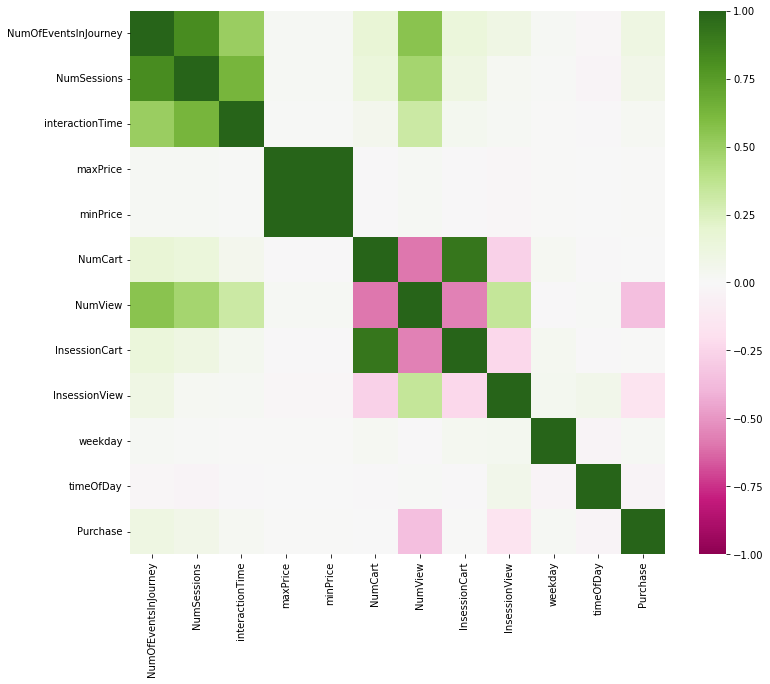

In [18]:
# Expected output:

3. Drop the features with high correlation.

    We'll do this by looking at each pair of features, and if they are highly correlated (at least 0.8), we won't include the second feature in the pair. Store the remaining set of features (the ones you didn't drop) in dataframes `train_df_reduced`. You are given the code, make sure that you understand what each line does.

In [24]:
import numpy as np

keep_columns = np.full(cor.shape[0], True)
for i in range(cor.shape[0] - 1):
    for j in range(i + 1, cor.shape[0] - 1):
        if (np.abs(cor.iloc[i, j]) >= 0.8):
            keep_columns[j] = False
selected_columns = train_df.columns[keep_columns]
train_df_reduced = train_df[selected_columns]

In [25]:
print(selected_columns) 

Index(['NumOfEventsInJourney', 'interactionTime', 'maxPrice', 'NumCart',
       'NumView', 'InsessionView', 'weekday', 'timeOfDay', 'Purchase'],
      dtype='object')


4. How many columns are left in the DataFrame?

In [26]:
# YOUR CODE HERE # Expected: The training data now has 8 features
print(f'The training data now has {len(train_df_reduced.columns) - 1} features')
# YOUR CODE HERE # Expected: The training data now has 8 features

The training data now has 8 features


In [27]:
train_df_reduced.columns

Index(['NumOfEventsInJourney', 'interactionTime', 'maxPrice', 'NumCart',
       'NumView', 'InsessionView', 'weekday', 'timeOfDay', 'Purchase'],
      dtype='object')

5. Remove the same features from the test set and save in a new dataframe `test_df_reduced`.

In [28]:
test_df_reduced = test_df[selected_columns]  # YOUR CODE HERE
test_df_reduced.shape # Expected: (430544, 9)

(430544, 9)

6. Visualize the selected features and discuss your observations with your team.

    Again, for faster rendering, use the subset `train_small_df_reduced`. If time permits, experiment with some other visualizations of the data.

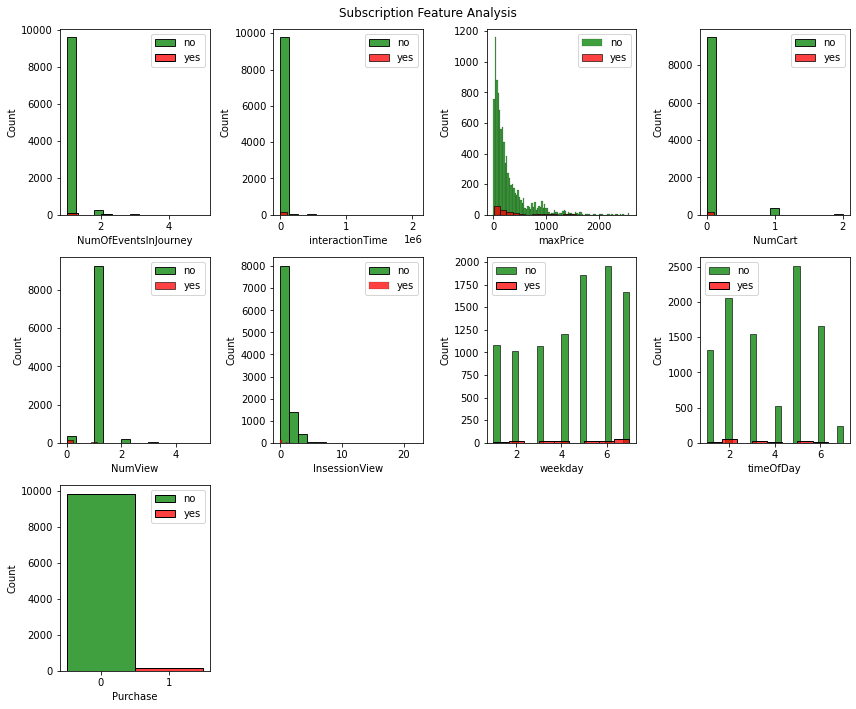

In [29]:
train_small_df_reduced = train_small_df[selected_columns]
fig = plt.figure(figsize=(12, 10))
j = 0
for i in train_df_reduced.columns:
    plt.subplot(3, 4, j + 1)
    j += 1
    sns.histplot(train_small_df_reduced[i][train_small_df_reduced['Purchase'] == 0], color='g', label='no')
    sns.histplot(train_small_df_reduced[i][train_small_df_reduced['Purchase'] == 1], color='r', label='yes')
    plt.legend(loc='best')
fig.suptitle('Subscription Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95);

7. Make the NumPy arrays `X_train_reduced`, `X_test_reduced`, `y_train` and `y_test` from `train_df_reduced` and `test_df_reduced`. 

In [30]:
y_train = train_df_reduced['Purchase'].values
y_test = test_df_reduced['Purchase'].values  # YOUR CODE HERE
X_train_reduced = train_df_reduced.drop(columns='Purchase').values
X_test_reduced = test_df_reduced.drop(columns='Purchase').values  # YOUR CODE HERE


8. Scale the features in `X_train_reduced` and `X_test_reduced` use `MinMaxScaler`

In [31]:
from sklearn.preprocessing import MinMaxScaler

scaler =  MinMaxScaler()  # YOUR CODE HERE
scaler.fit(X_train_reduced)
X_train_reduced = scaler.transform(X_train_reduced)  # YOUR CODE HERE
X_test_reduced = scaler.transform(X_test_reduced)  # YOUR CODE HERE

## Task 4: Build logistic regression and SVM models

We will be fitting both a Logistic Regression and SVM model to the reduced features and then looking at classification metrics such as Accuracy, Precision, Recall, and F1-score.

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score as accuracy,
    recall_score as recall,
    precision_score as precision,
    f1_score
)

1. Instantiate, train, and predict with the Logistic Regression model.

    Make sure to account for the imbalanced classes with with `class_weight` parameter.

    Remember to use the ***train*** data for building the model and the ***test*** data when making and evaluating the predictions

In [33]:
%%time
lr_model = LogisticRegression()  # YOUR CODE HERE
lr_model.fit(X_train_reduced, y_train)
lr_pred =  lr_model.predict(X_test_reduced) # YOUR CODE HERE

CPU times: user 12.1 s, sys: 434 ms, total: 12.5 s
Wall time: 6.8 s


2. Calculate these classification metrics for the Logistic Regression model:

    * accuracy
    * precision
    * recall
    * f1 score
    * confusion matrix

In [34]:
print("accuracy:", accuracy(y_test, lr_pred))
print("precision:", precision(y_test, lr_pred))
print("recall:", recall(y_test, lr_pred))
print("f1 score:", f1_score(y_test, lr_pred))
print("confusion matrix:")
print(confusion_matrix(y_test, lr_pred))

accuracy: 0.9988247426511576
precision: 0.9991109530583214
recall: 0.9181372549019607
f1 score: 0.9569141689373296
confusion matrix:
[[424419      5]
 [   501   5619]]


4. Instantiate, train and predict with the SVM mode. Check [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) for usage. 

    Again, remember to account fo the imbalanced classes.

In [36]:
%%time
svm_model = LinearSVC() # YOUR CODE HERE 
svm_model.fit(X_train_reduced, y_train)
svm_pred = svm_model.predict(X_test_reduced)

CPU times: user 12.5 s, sys: 504 ms, total: 13 s
Wall time: 13.1 s


5. What is the time complexity of SVM? What is it for Logistic Regression? Not familiar with the term "time complexity"? Take a read on [Computational Complexity of ML Models
](https://medium.com/analytics-vidhya/time-complexity-of-ml-models-4ec39fad2770).

    YOUR ANSWER HERE

In [ ]:
Logistic reg = O(nd)
SVM = O(n^2)

6. Calculate the classification metrics for the SVM model. Here you can use a helper function to display all the metrics, inspect the source code to understand how to use the function.

In [46]:
from utils import display_metrics
# YOUR CODE HERE
display_metrics(y_test, svm_pred)

Confusion Matrix: 
[[424424      0]
 [     0   6120]]
Accuracy: 1.000
Recall: 1.000
Precision: 1.000
F1 Score: 1.000


<details>
<summary> Expected output:</summary>

    Confusion Matrix: 
    [[424424      0]
    [     0   6120]]
    Accuracy: 1.000
    Recall: 1.000
    Precision: 1.000
    F1 Score: 1.000

</details>

Wow, that's impressive! Why do you think SVM performs so well? If you are not familiar with Support Vector Machine, check [In-Depth: Support Vector Machines](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb) out for better understanding. 

## Task 5: Fit a non-linear classifier: gradient boosted tree

1. Instantiate, train, and predict with the Gradient Boosted Trees model.

In [44]:
from sklearn.ensemble import GradientBoostingClassifier

In [45]:
%%time
gbt_model = GradientBoostingClassifier()  # YOUR CODE HERE
gbt_model.fit(X_train_reduced, y_train)
gbt_pred = gbt_model.predict(X_test_reduced)

CPU times: user 1min 14s, sys: 51.6 ms, total: 1min 14s
Wall time: 1min 14s


2. Evaluate the model by calculating the classification metrics.

In [43]:
display_metrics(y_test, gbt_pred)

Confusion Matrix: 
[[424422      2]
 [    16   6104]]
Accuracy: 1.000
Recall: 0.997
Precision: 1.000
F1 Score: 0.999


<details>
<summary> Expected output:</summary>

    Confusion Matrix: 
    [[424423      1]
    [    16   6104]]
    Accuracy: 1.000
    Recall: 0.997
    Precision: 1.000
    F1 Score: 0.999

</details>

## Task 6: Analyze importace of data sample balancing with random forest model

1. Instantiate, train, predict with, and evaluate an unbalanced random forest classifier. (Follow the same steps you did above with the other models). You can use 100 trees in the forest, and set the maximum depth of the tree at 5. 

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
%%time
rf_model =  RandomForestClassifier() # YOUR CODE HERE
rf_model.fit(X_train_reduced, y_train)
rf_pred = rf_model.predict(X_test_reduced)

CPU times: user 40.3 s, sys: 29.6 ms, total: 40.3 s
Wall time: 40.6 s


In [49]:
display_metrics(y_test, rf_pred)

Confusion Matrix: 
[[424422      2]
 [    44   6076]]
Accuracy: 1.000
Recall: 0.993
Precision: 1.000
F1 Score: 0.996


2. Repeat the previous exercise, but this time, incorporate **class-balanced penalty weights**

In [50]:
%%time
rf_model_b = RandomForestClassifier(class_weight="balanced")# YOUR CODE HERE
rf_model_b.fit(X_train_reduced, y_train)
rf_pred_b = rf_model_b.predict(X_test_reduced)

CPU times: user 52.7 s, sys: 235 ms, total: 52.9 s
Wall time: 53 s


In [39]:
display_metrics(y_test, rf_pred_b)

Confusion Matrix: 
[[421594   2830]
 [     0   6120]]
Accuracy: 0.993
Recall: 1.000
Precision: 0.684
F1 Score: 0.812


3. Visualize a Decision Tree. Spend some time inspecting this visualization of the tree--what does each line in the boxes mean? Discuss this with your partners. What does the "value=..." line indicate?

In [51]:
from sklearn.tree import export_graphviz
from subprocess import call

export_graphviz(rf_model_b.estimators_[0], max_depth=5, out_file='tree.dot', 
                feature_names = selected_columns[:-1],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
# MacOS: brew install graphviz
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

Image(filename = 'tree.png')

4. Look at the results below to note the most important features.

In the cell below we show you how to use a Random Forest to rank features based on a measure of importance called the Gini Importance. We'll provide you with all the code, but you may want to read up on sklearn's [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and its [feature_importances_](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_) property.

Feature ranking:
1. NumView (feature 4) (0.472291)
2. InsessionView (feature 5) (0.327716)
3. interactionTime (feature 1) (0.067111)
4. NumCart (feature 3) (0.062941)
5. NumOfEventsInJourney (feature 0) (0.056832)
6. weekday (feature 6) (0.005304)
7. maxPrice (feature 2) (0.003961)
8. timeOfDay (feature 7) (0.003844)


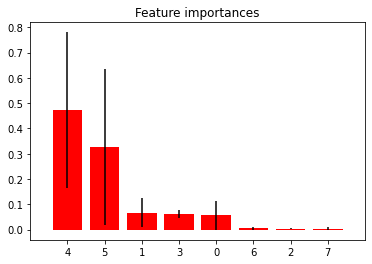

In [52]:
# Use Random Forest to get feature ranks/importances for each feature
importances = rf_model_b.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model_b.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train_reduced.shape[1]):
    print("%d. %s (feature %d) (%f)" %
          (f + 1, train_df_reduced.columns[indices[f]], indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_reduced.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_reduced.shape[1]), indices)
plt.xlim([-1, X_train_reduced.shape[1]]);

Thus features 4 and 5 (numview, InsessionView) are the top two most important features (according to the Random Forest model). Is this what you expected? Bonus question, is it necessary to scale features for when fitting random forest models?

## Optional Task: Explanability with SHAP

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions. You can use package [SHAP](https://github.com/slundberg/shap). 

For this optional task, if you are not familar with the concept, read the book chapter [Interpretable Machine Learning - A Guide for Making Black Box Models Explainable](https://christophm.github.io/interpretable-ml-book/shap.html) first. Can you apply `shap.Explainer()` to calculate the SHAP values for the XGBoost and Random Forest models you fit earlier, visualize the effects over all samples using `shap.plots.beeswarm()` and interpret the results? Consider experimenting it on a smaller dataset first. 

Want to get more details? Please go ahead and check these links:

1. [Interactive Shapley Value Demonstration in Python](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/Interactive_Shapley_Values.ipynb)
2. [Subsurface Data Analytics](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_Feature_Ranking.ipynb)

## References

- This work is motivated by the [publication](https://arxiv.org/pdf/2010.02503.pdf) 
- [Comprehensive Guide on Feature Selection](https://www.kaggle.com/code/prashant111/comprehensive-guide-on-feature-selection/notebook)
- [Common pitfalls and recommended practices](https://scikit-learn.org/stable/common_pitfalls.html)